In [1]:
#import libraries
from fastai.tabular.all import *
from fastai.collab import *
import pandas as pd

In [2]:
#load data
ratings = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ratings_small.csv')
metadata = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/movies_metadata_clean.csv')

In [3]:
#we will select movies with at least 50 votes, 80th percentile of votes
metadata_cf = metadata[metadata['vote_count']>=50][['id','title']]

#to select IDs of movies with vote count more than 50 in metadata_cf
movie_ids = [int(x) for x in metadata_cf['id'].values]

#select ratings of movies with more than 50 vote counts
ratings = ratings[ratings['movieId'].isin(movie_ids)][['userId','movieId', 'rating']]

#to reset index
ratings.reset_index(inplace=True, drop=True)

#movieId in ratings = id in metadata_cf, drop id column 
metadata_cf['movieId'] = metadata_cf['id'].astype(int)
metadata_cf = metadata_cf.drop('id', axis=1)

#merge ratings and metadata_cf to get title of movie as well
ratings = ratings.merge(metadata_cf)
ratings.head()

,userId,movieId,rating,title
0,1,1371,2.5,Rocky III
1,4,1371,4.0,Rocky III
2,7,1371,3.0,Rocky III
3,19,1371,4.0,Rocky III
4,21,1371,3.0,Rocky III


In [4]:
#By default, it takes the first column for user, the second column for the item (here our movies) and the third column for the ratings. 
#We need to change the value of item_name in our case, to use the titles instead of the ids
#bs = batch size, how many samples per batch to load

dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)

In [5]:
#assemble data with data loader and view with show batch
dls.show_batch()

,userId,title,rating
0,358,21 Grams,1.0
1,105,Titanic,3.5
2,161,Aliens vs Predator: Requiem,4.0
3,508,To Kill a Mockingbird,3.0
4,426,Boogie Nights,4.5
5,73,Bad Boys II,3.0
6,509,The Holiday,1.0
7,188,"Good Morning, Vietnam",3.0
8,213,The Chronicles of Riddick: Dark Fury,1.0
9,537,Cars,5.0


In [6]:
#fastai can create and train a collaborative filtering model by using collab_learner:
#n_factors default is 50, y_range is the rating of 0-5
#it uses a simple dot product model with 50 latent factors
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5), metrics=rmse)

SuggestedLRs(valley=0.010964781977236271)

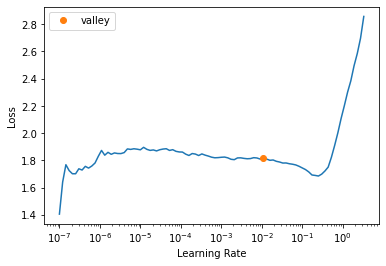

In [7]:
#to find the lowest loss with optimal learning rate
learn.lr_find()

In [8]:
#To train it using the 1cycle policy, we just run this command
#small weight decay wd of 0.1 for regularization, LR of 0.005
#best RMSE score of 0.87
learn.fit_one_cycle(5, 0.005, wd=0.1)

epoch,train_loss,valid_loss,_rmse,time
0,1.021607,0.905272,0.951458,00:07
1,0.756526,0.776046,0.880934,00:07
2,0.611625,0.754952,0.868880,00:04
3,0.438103,0.752038,0.867201,00:03
4,0.351677,0.753043,0.867780,00:03


In [9]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(672, 50)
  (i_weight): Embedding(1427, 50)
  (u_bias): Embedding(672, 1)
  (i_bias): Embedding(1427, 1)
)

In [10]:
#make predictions using DNN model

movie_names = list(metadata_cf.drop_duplicates(subset='movieId', keep='first').title)
size = len(movie_names)

def predict_top_movies(userId, count=5):
  query = { 'userId': [userId] * size, 'title': movie_names }
  query_df = pd.DataFrame(data=query)
  query_dl = dls.test_dl(query_df)
  preds, y = learn.get_preds(dl=query_dl)
  results = sorted(zip(preds, movie_names), reverse=True)[:count]
  for idx, (score, name) in enumerate(results):
    print("Score: ", round(float(score), 2), " for movie: ", name)

predict_top_movies(671)

Score:  4.67  for movie:  The Million Dollar Hotel
Score:  4.57  for movie:  Once Were Warriors
Score:  4.56  for movie:  The 39 Steps
Score:  4.51  for movie:  Laura
Score:  4.48  for movie:  And Then There Were None
